## Background, motivation and set up


**Objective**: Compare attributions using integrated gradients and activation patching, and investigate the discrepancies between the two methods.

**Background**: 

- Both integrated gradients (IG) and activation patching (AP) are used extensively in explainability and interpretability.
    - IG is path-based: integrates gradients along a path from a baseline to the input. 
    - AP is perturbation-based: directly measures causal effect of replacing activations.
- Activation patching can be approximated cheaply using methods inspired by integrated gradients; see [Hanna et al (2024)](https://arxiv.org/abs/2403.17806)
- Gradient-based attribution methods can be used to identify important model components as an alternative to activation patching; see [Ferrando and Voita (2024)](https://aclanthology.org/2024.emnlp-main.965/)
- Activation patching is often used as the "gold standard" to evaluate attribution methods

**Motivation**: 

- Understand when and why do IG and AP disagree: e.g. methodological limitations, or suitability to model tasks, etc.
- Investigate if discrepancies help uncover different hidden model behaviours
- Understand when and why linear approximations to activation patching fail
- Investigate limitations of using activation patching for evaluations: if results are different because of other unknown factors (not just because the method evaluated is "incorrect")

*Some ideas*:

- Components which might not be identified by activation patching: generic components which are used for both clean and corrupted examples in activation patching
- Components which might not be identified by integrated gradients: backup attention heads, components which only influence the output when interacting with other components, i.e. OR circuits

### Set-up

We load a pre-trained toy transformer which performs balanced bracket classification. The model has three layers, each with two attention heads and one MLP layer of 56 neurons.

<img src="reference/bracket-transformer-entire-model-short.png" alt="Transformer architecture" width="100%"/>

In [6]:
import importlib

import torch
from captum.attr import LayerIntegratedGradients, IntegratedGradients
import numpy as np
from transformer_lens.utils import get_act_name
from transformer_lens import ActivationCache
from transformer_lens.hook_points import HookPoint

import toy_transformers.toy_bracket_transformer as tt
importlib.reload(tt)
from toy_transformers.toy_bracket_transformer import load_toy_bracket_transformer, test_loaded_bracket_model

import seaborn as sns
import matplotlib.pyplot as plt


In [12]:
#| output: false

tokenizer, model = load_toy_bracket_transformer()

# Explicitly calculate and expose the result for each attention head and MLP input
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (hook_tokens): HookPoint()
  (blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out):

# Initial results

### Evaluating baselines for integrated gradients

We need to choose an appropriate baseline to calculate Integrated Gradients from. An ideal baseline input will produce a final output which is close to zero, and meaningfully represents a lack of information (see Sundararajan et al. 2017). 

Here we test a series of inputs which are feasible baseline inputs, and check their final classification scores.

In [13]:
def run_from_layer_fn(x, original_input, prev_layer):
    # Force the layer before the target layer to output the given values, i.e. pass the given input into the target layer
    # original_input value does not matter; useful to keep shapes nice, but its activations will be overwritten
    output = model.run_with_hooks(
        original_input,
        fwd_hooks=[(prev_layer.name, lambda act, hook: x)]
    )
    logits = output[:, 0]
    return logits.softmax(-1)[:, 1]

def compute_layer_to_output_attributions(original_input, layer_input, layer_baseline, target_layer, prev_layer):
    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(x, original_input, prev_layer)
    # Attribute to the target_layer's output
    ig_embed = LayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
    attributions, approximation_error = ig_embed.attribute(inputs=layer_input,
                                                    baselines=layer_baseline, 
                                                    attribute_to_layer_input=False,
                                                    return_convergence_delta=True)
    print(f"\nError (delta) for {target_layer.name} attribution: {approximation_error.item()}")
    return attributions

In [8]:
#| code-fold: false

# The prediction at the baseline should be near zero (see Sundararajan et al. 2017)
# Here we test a series of inputs which could be a baseline, and check their final classification scores

def predict_balanced(x):
    logits = model(x)[:, 0]
    return logits.softmax(-1)[:, 1].item()

balanced_input = tokenizer.tokenize("()()")
print("Input: ()()", balanced_input)
print("Output:", predict_balanced(balanced_input), "\n")

unbalanced_input = tokenizer.tokenize("(()(")
print("Input: (()(", unbalanced_input)
print("Output:", predict_balanced(unbalanced_input), "\n")

all_padding = torch.full_like(balanced_input, tokenizer.PAD_TOKEN)
print("Input: PAD PAD PAD PAD PAD PAD", all_padding)
print("Output:", predict_balanced(all_padding), "\n")

mask = np.isin(balanced_input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
start_pad_end = balanced_input * mask + tokenizer.PAD_TOKEN * (1 - mask)
print("Input: START PAD PAD PAD PAD END", start_pad_end)
print("Output:", predict_balanced(start_pad_end), "\n")

all_zeroes = torch.zeros_like(balanced_input)
print("Input: (all zeroes)", all_zeroes)
print("Output:", predict_balanced(all_zeroes), "\n")


print("Patch zeroes in at target component, e.g. MLP neurons in layer 1\n")

prev_layer_hook = get_act_name("post", 1)
prev_layer = model.hook_dict[prev_layer_hook]

for input in [balanced_input, unbalanced_input, all_padding, start_pad_end, all_zeroes]:
    _, test_cache = model.run_with_cache(input)
    prev_layer_acts = test_cache[prev_layer_hook]
    prev_layer_acts[:, :] = torch.zeros(prev_layer_acts.size(2))

    print("Input with patching:", input)
    print("Output:", run_from_layer_fn(prev_layer_acts, input, prev_layer).item(), "\n")

Input: ()() tensor([[0, 3, 4, 3, 4, 2]])
Output: 0.9999862909317017 

Input: (()( tensor([[0, 3, 3, 4, 3, 2]])
Output: 1.8626720702741295e-05 

Input: PAD PAD PAD PAD PAD PAD tensor([[1, 1, 1, 1, 1, 1]])
Output: 0.04108979180455208 

Input: START PAD PAD PAD PAD END tensor([[0, 1, 1, 1, 1, 2]])
Output: 3.6776664273929782e-06 

Input: (all zeroes) tensor([[0, 0, 0, 0, 0, 0]])
Output: 1.5444304153788835e-05 

Patch zeroes in at target component, e.g. MLP neurons in layer 1

Input with patching: tensor([[0, 3, 4, 3, 4, 2]])
Output: 0.9983036518096924 

Input with patching: tensor([[0, 3, 3, 4, 3, 2]])
Output: 0.00015179907495621592 

Input with patching: tensor([[1, 1, 1, 1, 1, 1]])
Output: 0.0017063161358237267 

Input with patching: tensor([[0, 1, 1, 1, 1, 2]])
Output: 2.0060035240021534e-05 

Input with patching: tensor([[0, 0, 0, 0, 0, 0]])
Output: 6.123560524429195e-06 



The `[START, PAD, END]` token sequence seems to be the best baseline, because it produces a final output which is consistently closest to zero, and this sequence meaningfully represents an input with no information. 

Forcing zero activations to be fed into the target component (i.e. patching zeroes in) does not seem to have much of an effect on the final output. This is probably because, even though we overwrite the activations fed into the target component with zeros, the original input continues to be processed due to the residual stream in the transformer model.

Therefore, at the present, it doesn't seem to really matter whether or not we patch in zero activations before the target component, as long as we use input `[START, PAD, END]`. Intuitively, it makes sense to patch in zero activations as the baseline for IG, as this is the default baseline.

### Basic Integrated Gradients

We perform integrated gradients for a balanced input sequence `()()`. The baseline used is zero activations fed into the target components, and the original input as `[START, PAD, END]`.

In [14]:
# Gradient attribution for neurons in MLP layers
mlp_ig_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Gradient attribution for attention heads
attn_ig_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
input = tokenizer.tokenize("()()")
mask = np.isin(input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
baseline = input * mask + tokenizer.PAD_TOKEN * (1 - mask)

_, input_cache = model.run_with_cache(input)
_, baseline_cache = model.run_with_cache(baseline)

for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("z", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = input_cache[prev_layer_hook]
    layer_corrupt_input = baseline_cache[prev_layer_hook]

    attributions = compute_layer_to_output_attributions(input, layer_clean_input, layer_corrupt_input, target_layer, prev_layer) # shape [1, seq_len, d_head, d_model]
    # Calculate attribution score based on mean over each embedding, for each token
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_results[layer] = score

    # Gradient attribution on MLP neurons
    hook_name = get_act_name("post", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("mlp_in", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = input_cache[prev_layer_hook]
    layer_corrupt_input = baseline_cache[prev_layer_hook]
    
    attributions = compute_layer_to_output_attributions(input, layer_clean_input, layer_corrupt_input, target_layer, prev_layer) # shape [1, seq_len, d_model]
    score = attributions.mean(dim=1)
    mlp_ig_results[layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: -0.063778817653656

Error (delta) for blocks.0.mlp.hook_post attribution: -0.0020977258682250977

Error (delta) for blocks.1.attn.hook_result attribution: 0.00013774633407592773

Error (delta) for blocks.1.mlp.hook_post attribution: -4.172325134277344e-07

Error (delta) for blocks.2.attn.hook_result attribution: -0.0004189014434814453

Error (delta) for blocks.2.mlp.hook_post attribution: 2.578872226877138e-09


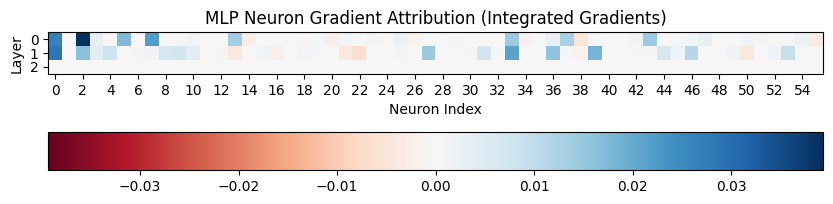

In [7]:
bound = max(torch.max(mlp_ig_results), abs(torch.min(mlp_ig_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_ig_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients)")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

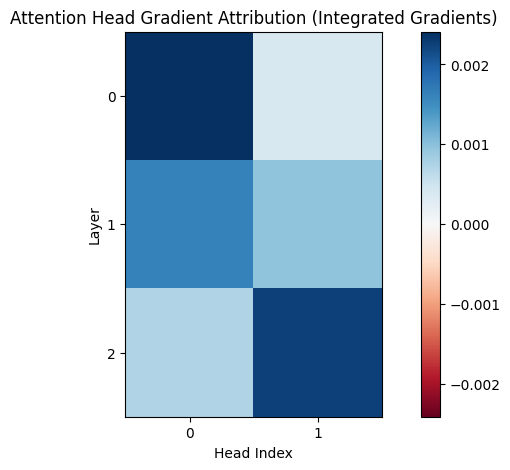

In [16]:
bound = max(torch.max(attn_ig_results), abs(torch.min(attn_ig_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients)")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

### Basic Activation Patching (Causal Tracing)

Noising (a corrupt → clean patch) shows whether the patched activations were *necessary* to maintain the model behaviour. Therefore we patch corrupted activations into a clean run.

In [17]:
#| output: false

from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.hook_points import HookPoint

clean_input = tokenizer.tokenize("()()")        # Balanced
corrupted_input = tokenizer.tokenize("(()(")    # Unbalanced

# We run on the corrupted prompt with the cache so we store activations to patch in later.
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_input)
clean_logits = model(clean_input)

# Get probability of overall sequence being balanced (class 1) from position 0
clean_answer_logits = clean_logits[0, 0, 1]
corrupted_answer_logits = corrupted_logits[0, 0, 1]
print(f"Balanced input score: {clean_answer_logits}")
print(f"Unbalanced input score: {corrupted_answer_logits}")

baseline_diff = (corrupted_answer_logits - clean_answer_logits).item()
print(f"Baseline clean-corrupted logit difference: {baseline_diff:.2f}")

Balanced input score: 5.693811416625977
Unbalanced input score: -5.421151161193848
Baseline clean-corrupted logit difference: -11.11


In [18]:
# Patch neurons in MLP layers
mlp_patch_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Patch attention heads
attn_patch_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

def patch_neuron_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, neuron_idx: int):
    # Replace the activations for the target neuron with activations from the cached run.
    cached_activations = cache[hook.name]
    activations[:, :, neuron_idx] = cached_activations[:, :, neuron_idx]
    return activations

def patch_attn_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, head_idx: int):
    # Replace the activations for the target attention head with activations from the cached run.
    cached_activations = cache[hook.name]
    activations[:, :, head_idx, :] = cached_activations[:, :, head_idx, :]
    return activations


for layer in range(model.cfg.n_layers):
    # Activation patching on heads
    for head in range(model.cfg.n_heads):
        hook_name = get_act_name("result", layer)
        temp_hook = lambda act, hook: patch_attn_hook(act, hook, corrupted_cache, head)

        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_input)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - clean_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        attn_patch_results[layer, head] = logit_diff / baseline_diff

    # Activation patching on MLP neurons
    for neuron in range(model.cfg.d_mlp):
        hook_name = get_act_name("post", layer)
        temp_hook = lambda act, hook: patch_neuron_hook(act, hook, corrupted_cache, neuron)
        
        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_input)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - clean_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        mlp_patch_results[layer, neuron] = logit_diff / baseline_diff

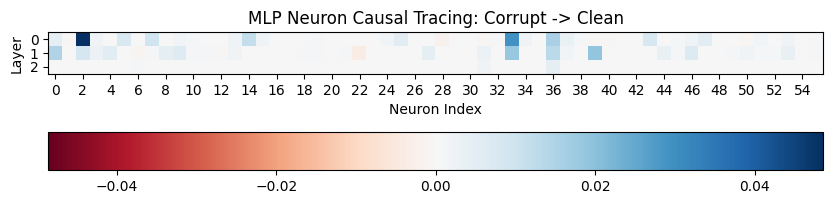

In [19]:
bound = max(torch.max(mlp_patch_results), abs(torch.min(mlp_patch_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_patch_results, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Causal Tracing: Corrupt -> Clean")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

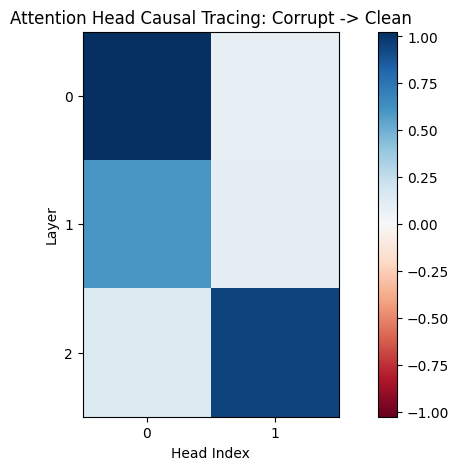

In [20]:
bound = max(torch.max(attn_patch_results), abs(torch.min(attn_patch_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_patch_results, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Causal Tracing: Corrupt -> Clean")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

# Comparison metrics

In [21]:
mlp_ig_results = mlp_ig_results.detach()
attn_ig_results = attn_ig_results.detach()

### Correlation between attribution scores

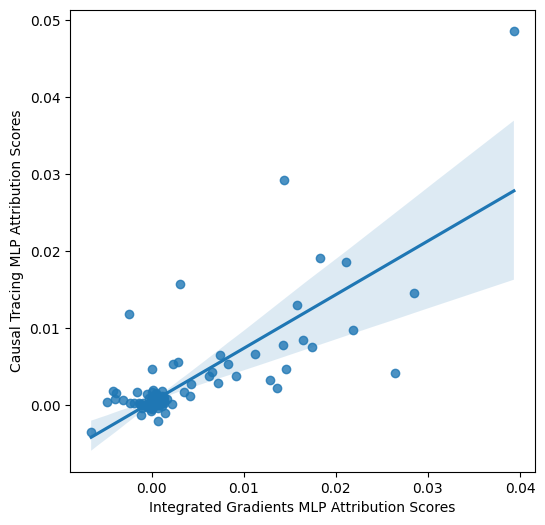

Correlation coefficient between IG and causal tracing attributions for neurons: 0.7884283746567423


In [22]:
# Plot the attribution scores against each other. Correlation: y = x.

x = mlp_ig_results.flatten().numpy()
y = mlp_patch_results.flatten().numpy()

plt.figure(figsize=(6,6))
sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients MLP Attribution Scores")
plt.ylabel("Causal Tracing MLP Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG and causal tracing attributions for neurons: {np.corrcoef(x, y)[0, 1]}")

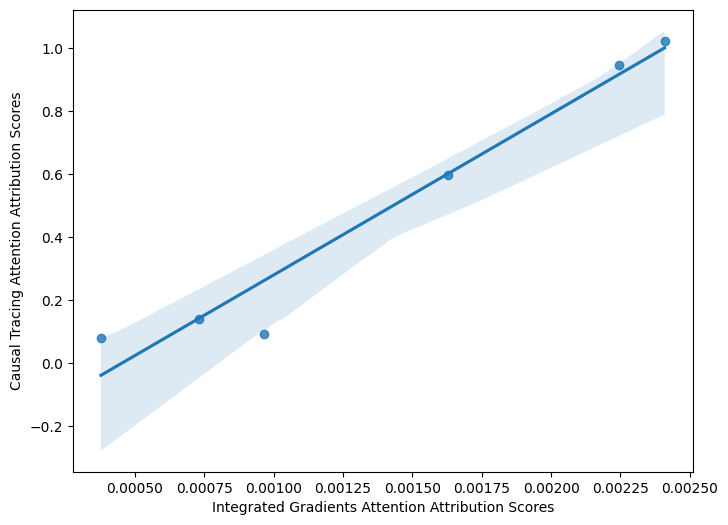

Correlation coefficient between IG and causal tracing attributions for attention: 0.9761361003061142


In [23]:
x = attn_ig_results.flatten().numpy()
y = attn_patch_results.flatten().numpy()

plt.figure(figsize=(8,6))
sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients Attention Attribution Scores")
plt.ylabel("Causal Tracing Attention Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG and causal tracing attributions for attention: {np.corrcoef(x, y)[0, 1]}")

### Agreement between attribution scores

The Jaccard scores for MLP neuron attribution scores per transformer layer is low.

In [36]:

def get_top_k_by_abs(data, k):
    _, indices = torch.topk(data.flatten().abs(), k)
    top_k_values = torch.gather(data.flatten(), 0, indices)
    formatted_indices = []
    for idx in indices:
        layer = idx // model.cfg.d_mlp
        neuron_pos = idx % model.cfg.d_mlp
        formatted_indices.append([layer, neuron_pos])
    return torch.tensor(formatted_indices), top_k_values

def get_attributions_above_threshold(data, percentile):
    threshold = torch.min(data) + percentile * (torch.max(data) - torch.min(data))
    masked_data = torch.where(data > threshold, data, 0)
    nonzero_indices = torch.nonzero(masked_data)
    return nonzero_indices, masked_data

# top_mlp_ig_indices, top_mlp_ig_results = get_attributions_above_threshold(mlp_ig_results, 0.5)
# top_mlp_patch_indices, top_mlp_patch_results = get_attributions_above_threshold(mlp_patch_results, 0.5)

top_mlp_ig_indices, top_mlp_ig_results = get_top_k_by_abs(mlp_ig_results, 30)
top_mlp_patch_indices, top_mlp_patch_results = get_top_k_by_abs(mlp_patch_results, 30)
print(top_mlp_ig_indices.shape, top_mlp_patch_indices.shape)

torch.Size([30, 2]) torch.Size([30, 2])


In [37]:
# top_mlp_ig_sets = [set(row.tolist()) for row in top_mlp_ig_indices]
# top_mlp_patch_sets = [set(row.tolist()) for row in top_mlp_patch_indices]
top_mlp_ig_sets = set([tuple(t.tolist()) for t in top_mlp_ig_indices])
top_mlp_patch_sets = set([tuple(t.tolist()) for t in top_mlp_patch_indices])

intersection = top_mlp_ig_sets.intersection(top_mlp_patch_sets)
union = top_mlp_ig_sets.union(top_mlp_patch_sets)
jaccard = len(intersection) / len(union)

print(f"Jaccard score for MLP neurons: {jaccard}")

Jaccard score for MLP neurons: 0.6216216216216216


In [38]:
def indices_set_to_binary_matrix(set_indices, shape):
    binary_mat = torch.zeros(shape, dtype=torch.long)
    for i, j in set_indices:
        binary_mat[i, j] = 1
    return binary_mat

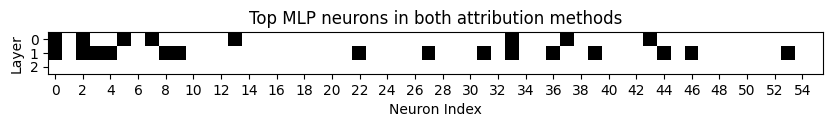

In [39]:
binary_mat_intersections = indices_set_to_binary_matrix(intersection, mlp_ig_results.shape)

plt.figure(figsize=(10, 8))
plt.imshow(binary_mat_intersections, cmap="Greys")
plt.title("Top MLP neurons in both attribution methods")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.show()

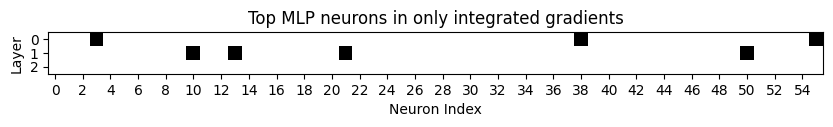

In [40]:
top_mlp_ig_exclusive = top_mlp_ig_sets.difference(top_mlp_patch_sets)

binary_mat_ig_exclusive = indices_set_to_binary_matrix(top_mlp_ig_exclusive, mlp_ig_results.shape)

plt.figure(figsize=(10, 8))
plt.imshow(binary_mat_ig_exclusive, cmap="Greys")
plt.title("Top MLP neurons in only integrated gradients")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.show()

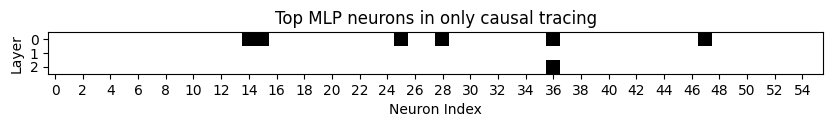

In [41]:
top_mlp_patch_exclusive = top_mlp_patch_sets.difference(top_mlp_ig_sets)

binary_mat_patch_exclusive = indices_set_to_binary_matrix(top_mlp_patch_exclusive, mlp_patch_results.shape)

plt.figure(figsize=(10, 8))
plt.imshow(binary_mat_patch_exclusive, cmap="Greys")
plt.title("Top MLP neurons in only causal tracing")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.show()

### Measuring agreement: Tukey mean-difference plot

Assumptions: the two attribution methods have the same precision, the precision is constant and does not depend on the "true" attribution score, and the difference between the two methods is constant.

NOTE: since the scales of measurement may be different, this may not be applicable.

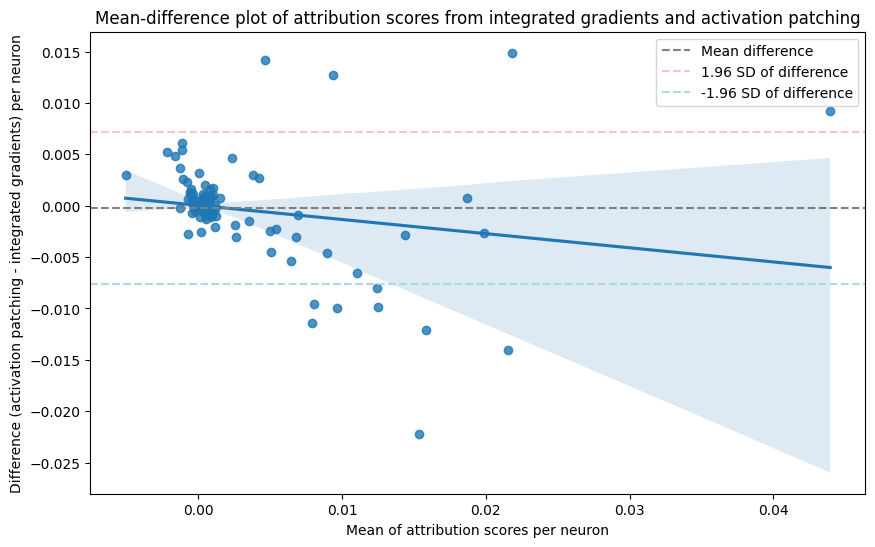

In [42]:
from sklearn.preprocessing import MaxAbsScaler

mlp_ig_results_1d = mlp_ig_results.flatten().numpy()
mlp_patch_results_1d = mlp_patch_results.flatten().numpy()

# Mean-difference plots

mean = np.mean([mlp_ig_results_1d, mlp_patch_results_1d], axis=0)
diff = mlp_patch_results_1d - mlp_ig_results_1d
md = np.mean(diff) # Mean of the difference
sd = np.std(diff, axis=0) # Standard deviation of the difference

plt.figure(figsize=(10, 6))
sns.regplot(x=mean, y=diff, fit_reg=True, scatter=True)
plt.axhline(md, color='gray', linestyle='--', label="Mean difference")
plt.axhline(md + 1.96*sd, color='pink', linestyle='--', label="1.96 SD of difference")
plt.axhline(md - 1.96*sd, color='lightblue', linestyle='--', label="-1.96 SD of difference")
plt.xlabel("Mean of attribution scores per neuron")
plt.ylabel("Difference (activation patching - integrated gradients) per neuron")
plt.title("Mean-difference plot of attribution scores from integrated gradients and activation patching")
plt.legend()
plt.show()

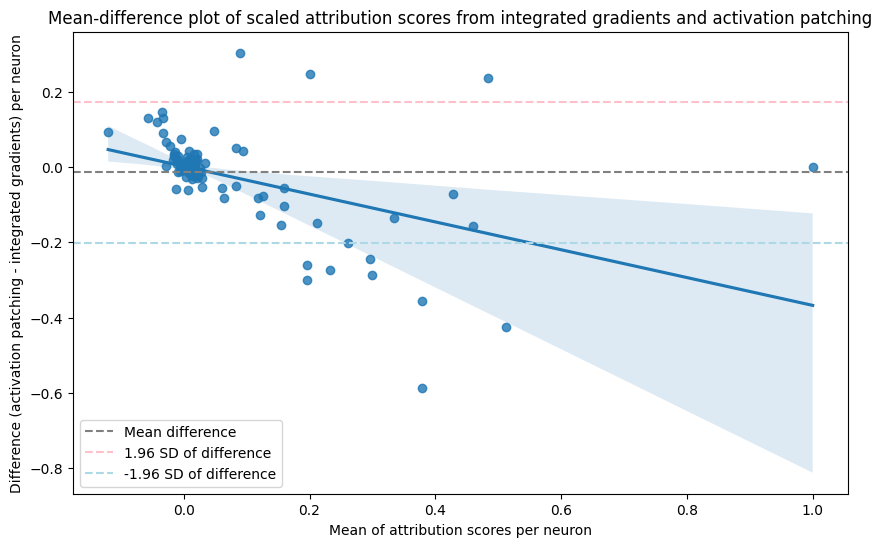

In [43]:
# Mean difference plot with scaled data

scaled_mlp_ig_results_1d = MaxAbsScaler().fit_transform(mlp_ig_results_1d.reshape(-1, 1))
scaled_mlp_patch_results_1d = MaxAbsScaler().fit_transform(mlp_patch_results_1d.reshape(-1, 1))

mean = np.mean([scaled_mlp_ig_results_1d, scaled_mlp_patch_results_1d], axis=0)
diff = scaled_mlp_patch_results_1d - scaled_mlp_ig_results_1d
md = np.mean(diff) # Mean of the difference
sd = np.std(diff, axis=0) # Standard deviation of the difference

plt.figure(figsize=(10, 6))
sns.regplot(x=mean, y=diff, fit_reg=True, scatter=True)
plt.axhline(md, color='gray', linestyle='--', label="Mean difference")
plt.axhline(md + 1.96*sd, color='pink', linestyle='--', label="1.96 SD of difference")
plt.axhline(md - 1.96*sd, color='lightblue', linestyle='--', label="-1.96 SD of difference")
plt.xlabel("Mean of attribution scores per neuron")
plt.ylabel("Difference (activation patching - integrated gradients) per neuron")
plt.title("Mean-difference plot of scaled attribution scores from integrated gradients and activation patching")
plt.legend()
plt.show()

- Mean difference is close to zero, indicating a lack of fixed bias: methods tend to agree.
- Deviation from the mean difference increases as the average attribution score increases, indicating proportional bias. Methods tend to agree on which neurons contribute less to the output, but disagree more on neurons which are identified as important by one/both of the methods. Specifically, for larger attribution scores, integrated gradients assigns greater attribution scores to neurons than causal tracing.
- The limits of agreement (95% of the differences between attribution scores) lie within approximately -0.007 to 0.010. This is a fairly small but still noticeable range of error, given that the difference in attribution scores lies between -0.009 and 0.030.


### Difference in scores for attention heads

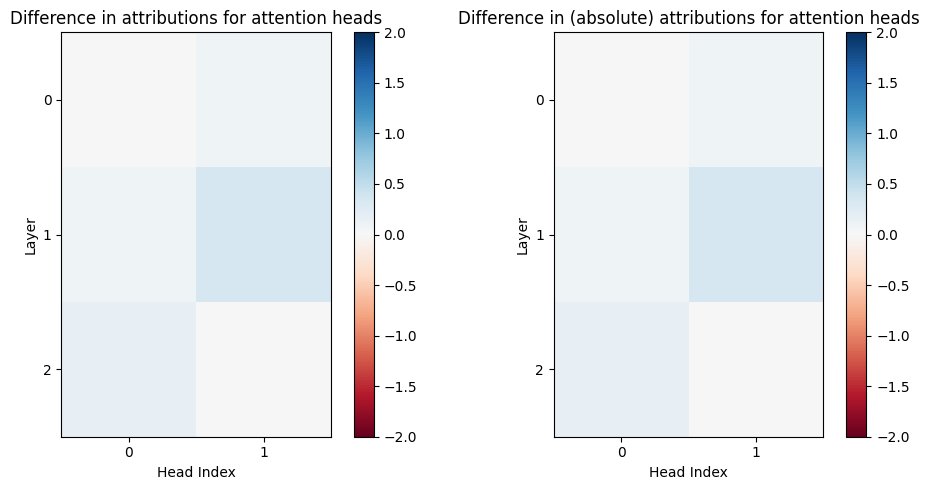

In [44]:
from sklearn.preprocessing import MaxAbsScaler

scaled_attn_ig_results = MaxAbsScaler().fit_transform(attn_ig_results)
scaled_attn_patch_results = MaxAbsScaler().fit_transform(attn_patch_results)

diff_attn_results = scaled_attn_ig_results - scaled_attn_patch_results
diff_attn_results_abs = np.abs(scaled_attn_ig_results) - np.abs(scaled_attn_patch_results)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(diff_attn_results, cmap="RdBu", vmin=-2, vmax=2)
plt.title("Difference in attributions for attention heads")

plt.xlabel("Head Index")
plt.xticks([0,1])
plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(diff_attn_results_abs, cmap="RdBu", vmin=-2, vmax=2)
plt.title("Difference in (absolute) attributions for attention heads")

plt.xlabel("Head Index")
plt.xticks([0,1])
plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.tight_layout()
plt.show()

### Comparison to "ground truth"

An in-depth investigation of the balanced bracket classifer reached the following circuit hypothesis:

- Head 0.0 allowed the first token to attend to all tokens in the sequence uniformly, and tally up `(left - right)` bracket counts.
- Neurons in MLP 0 activated when `(left - right) > 0` and neurons in MLP 1 activated when `(left - right) < 0`, and write boolean information about `left == right`.
- Head 2.0 copied information from position 1 to position 0 (which is used for the final classification).

Observations about neurons in the MLP layers which have a significant impact on the vector output in the unbalanced direction (class 0):

- Some neurons detect when the open-proportion is greater than 1/2, e.g. neurons 1.53, 1.39, 1.8 in layer 1. There are some in layer 0 as well, such as 0.33 or 0.43. Overall these seem more common in Layer 1.
- Some neurons detect when the open-proportion is less than 1/2. For instance, neurons 0.21, and 0.7. These are much more rare in layer 1, but you can see some such as 1.50 and 1.6.
- In layer 1 that there are many neurons that output a composed property (activate when proportions are imbalanced in either direction). As a few examples, look at 1.10 and 1.3. It's much harder for a single neuron in layer 0 to do this by themselves, given that ReLU is monotonic and it requires the output to be a non-monotonic function of the open-paren proportion. It is possible, however, to take advantage of the layernorm before mlp0 to approximate this -- 0.19 and 0.34 are good examples of this.
Note, there are some neurons which appear to work in the opposite direction (e.g. 0.0). It's unclear exactly what the function of these neurons is.

We identify the "true" important neurons in the MLP layers using neuron contribution plots (see tutorial ![Balanced Bracket Classifier section 3.1](reference/[1_5_1]_Balanced_Bracket_Classifier_(solutions).ipynb)). Neuron contribution is defined as the dot product (similarity) between the neuron's output vector to the residual stream, and the unbalanced direction (residual stream vector which causes highest probability for unbalanced class). Note that the tutorial only investigates the MLP neurons in the first two layers.

Using the "true" important neurons, measure the accuracy, precision, F1 and Jaccard score of each attribution method.

In [45]:
# Reference "ground truth" important neuron indices: (layer_id, neuron_idx)
reference_opposite_mlp_indices = [(0,0), (0,2), (0,20), (0,23), (0,31), (0,37), (0,38), (0,48), (0,54), (1,36), (1,38)]
reference_more_open_mlp_indices = [(0,33), (0,43), (1,8), (1,31), (1,39), (1,53)]
reference_less_open_mlp_indices = [(0,7), (0,12), (0,21), (0,50), (1,50)]
reference_composed_mlp_indices = [(0,10), (0,19), (0,34), (1,3), (1,10)]

reference_all_mlp_indices = reference_opposite_mlp_indices + reference_more_open_mlp_indices + reference_less_open_mlp_indices + reference_composed_mlp_indices

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, jaccard_score, confusion_matrix, ConfusionMatrixDisplay

top_mlp_ig_binary_mat = indices_set_to_binary_matrix(top_mlp_ig_indices, mlp_ig_results.shape)
top_mlp_patch_binary_mat = indices_set_to_binary_matrix(top_mlp_patch_indices, mlp_patch_results.shape)
reference_all_mlp_binary_mat = torch.zeros((2, top_mlp_ig_binary_mat.shape[1]), dtype=torch.long)
for i, j in reference_all_mlp_indices:
    reference_all_mlp_binary_mat[i,j] = 1.0


reference_all_mlp_binary_1d = reference_all_mlp_binary_mat.flatten()
top_mlp_ig_binary_1d = torch.cat((top_mlp_ig_binary_mat[0], top_mlp_ig_binary_mat[1])) # Only include first two layers to compare to ground truth
top_mlp_patch_binary_1d = torch.cat((top_mlp_patch_binary_mat[0], top_mlp_patch_binary_mat[1]))

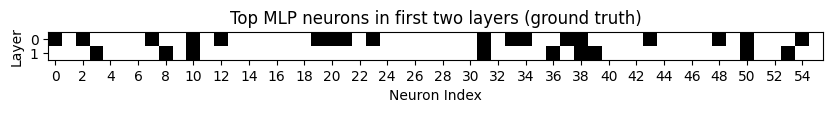

In [47]:
plt.figure(figsize=(10, 8))
plt.imshow(reference_all_mlp_binary_mat, cmap="Greys")
plt.title("Top MLP neurons in first two layers (ground truth)")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1])
plt.ylabel("Layer")
plt.show()

Integrated gradients accuracy: 0.7589285714285714
Integrated gradients precision: class 0 (low contribution) 0.8536585365853658, class 1 (high contribution) 0.5
Integrated gradients recall: class 0 (low contribution) 0.8235294117647058, class 1 (high contribution) 0.5555555555555556
Integrated gradients Jaccard score: class 0 (low contribution) 0.7216494845360825, class 1 (high contribution) 0.35714285714285715


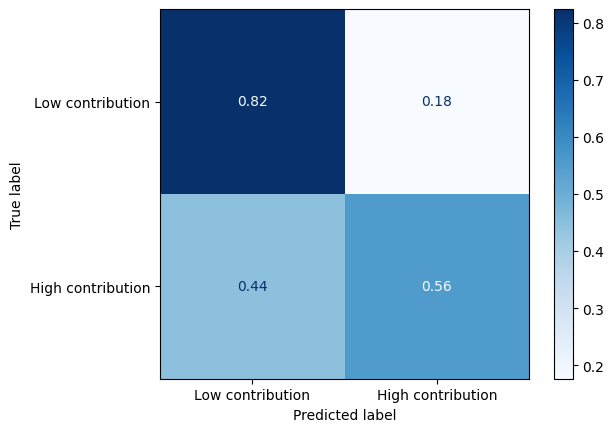

In [48]:
ig_accuracy = accuracy_score(reference_all_mlp_binary_1d, top_mlp_ig_binary_1d)
print(f"Integrated gradients accuracy: {ig_accuracy}")

ig_precision_0, ig_precision_1 = precision_score(reference_all_mlp_binary_1d, top_mlp_ig_binary_1d, average=None)
print(f"Integrated gradients precision: class 0 (low contribution) {ig_precision_0}, class 1 (high contribution) {ig_precision_1}")

ig_recall_0, ig_recall_1 = recall_score(reference_all_mlp_binary_1d, top_mlp_ig_binary_1d, average=None)
print(f"Integrated gradients recall: class 0 (low contribution) {ig_recall_0}, class 1 (high contribution) {ig_recall_1}")

ig_jaccard_0, ig_jaccard_1 = jaccard_score(reference_all_mlp_binary_1d, top_mlp_ig_binary_1d, average=None)
print(f"Integrated gradients Jaccard score: class 0 (low contribution) {ig_jaccard_0}, class 1 (high contribution) {ig_jaccard_1}")


ig_confusion_matrix = confusion_matrix(reference_all_mlp_binary_1d, top_mlp_ig_binary_1d, normalize="true")
ig_cm_display = ConfusionMatrixDisplay(ig_confusion_matrix, display_labels=["Low contribution", "High contribution"])
ig_cm_display.plot(cmap="Blues")
plt.show()

Causal tracing accuracy: 0.7142857142857143
Causal tracing precision: class 0 (low contribution) 0.8192771084337349, class 1 (high contribution) 0.41379310344827586
Causal tracing recall: class 0 (low contribution) 0.8, class 1 (high contribution) 0.4444444444444444
Causal tracing Jaccard score: class 0 (low contribution) 0.68, class 1 (high contribution) 0.2727272727272727


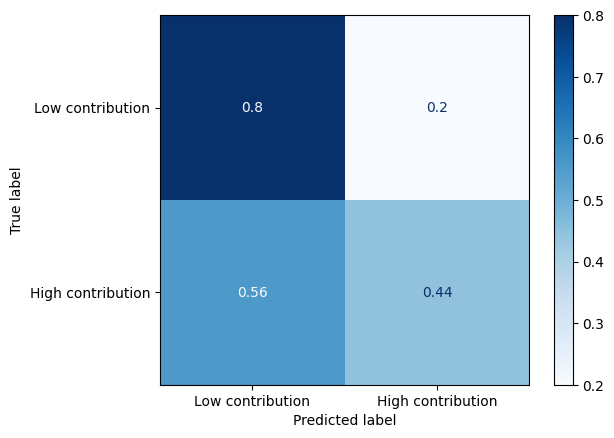

In [49]:
patch_accuracy = accuracy_score(reference_all_mlp_binary_1d, top_mlp_patch_binary_1d)
print(f"Causal tracing accuracy: {patch_accuracy}")

patch_precision_0, patch_precision_1 = precision_score(reference_all_mlp_binary_1d, top_mlp_patch_binary_1d, average=None)
print(f"Causal tracing precision: class 0 (low contribution) {patch_precision_0}, class 1 (high contribution) {patch_precision_1}")

patch_recall_0, patch_recall_1 = recall_score(reference_all_mlp_binary_1d, top_mlp_patch_binary_1d, average=None)
print(f"Causal tracing recall: class 0 (low contribution) {patch_recall_0}, class 1 (high contribution) {patch_recall_1}")

patch_jaccard_0, patch_jaccard_1 = jaccard_score(reference_all_mlp_binary_1d, top_mlp_patch_binary_1d, average=None)
print(f"Causal tracing Jaccard score: class 0 (low contribution) {patch_jaccard_0}, class 1 (high contribution) {patch_jaccard_1}")


patch_confusion_matrix = confusion_matrix(reference_all_mlp_binary_1d, top_mlp_patch_binary_1d, normalize="true")
patch_cm_display = ConfusionMatrixDisplay(patch_confusion_matrix, display_labels=["Low contribution", "High contribution"])
patch_cm_display.plot(cmap="Blues")
plt.show()

Integrated gradients and causal tracing seem to perform almost identically in terms of identifying known circuit neurons. Both methods identify true negatives and false negatives most of the time.

# Factors which impact Integrated Gradients

### Sensitivity to input: opposite classification

*Aim*: Verify that results (and implementation) are reasonable.

Repeat IG attribution with unbalanced sequence for comparison.

In [52]:
# Gradient attribution for neurons in MLP layers
mlp_ig_unbalanced_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Gradient attribution for attention heads
attn_ig_unbalanced_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
input = tokenizer.tokenize("(()(")
mask = np.isin(input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
baseline = input * mask + tokenizer.PAD_TOKEN * (1 - mask)

_, input_cache = model.run_with_cache(input)
_, baseline_cache = model.run_with_cache(baseline)

for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("z", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = input_cache[prev_layer_hook]
    layer_corrupt_input = baseline_cache[prev_layer_hook]

    attributions = compute_layer_to_output_attributions(input, layer_clean_input, layer_corrupt_input, target_layer, prev_layer) # shape [1, seq_len, d_head, d_model]
    # Calculate attribution score based on mean over each embedding, for each token
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_unbalanced_results[layer] = score

    # Gradient attribution on MLP neurons
    hook_name = get_act_name("post", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("mlp_in", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = input_cache[prev_layer_hook]
    layer_corrupt_input = baseline_cache[prev_layer_hook]
    
    attributions = compute_layer_to_output_attributions(input, layer_clean_input, layer_corrupt_input, target_layer, prev_layer) # shape [1, seq_len, d_model]
    score = attributions.mean(dim=1)
    mlp_ig_unbalanced_results[layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: 3.848981577903032e-09

Error (delta) for blocks.0.mlp.hook_post attribution: -9.094947017729282e-11

Error (delta) for blocks.1.attn.hook_result attribution: 3.5652192309498787e-10

Error (delta) for blocks.1.mlp.hook_post attribution: -1.6370904631912708e-11

Error (delta) for blocks.2.attn.hook_result attribution: 1.4551915228366852e-11

Error (delta) for blocks.2.mlp.hook_post attribution: -2.2737367544323206e-11


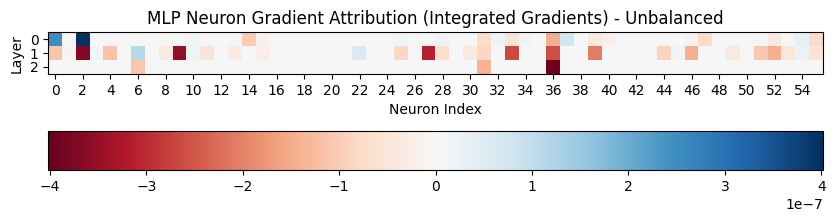

In [53]:
bound = max(torch.max(mlp_ig_unbalanced_results), abs(torch.min(mlp_ig_unbalanced_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_ig_unbalanced_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients) - Unbalanced")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

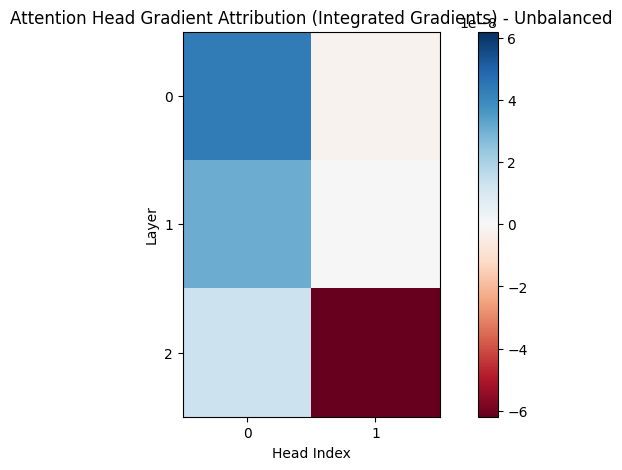

In [54]:
bound = max(torch.max(attn_ig_unbalanced_results), abs(torch.min(attn_ig_unbalanced_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_unbalanced_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients) - Unbalanced")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

Gradient attribution scores for neurons and attention heads change when the sequence is unbalanced. Notably, head 2.1 contributes significantly more highly to a positive "unbalanced" classification. This suggests that head 2.1 plays a strong role in the final output. The attribution scores for the other attention heads are less strong, suggesting a weaker role. Overall, this seems to confirm that IG is sensitive to the input as expected.

### Empty string attributions: sanity check

In [55]:
# Gradient attribution for neurons in MLP layers
mlp_ig_empty_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Gradient attribution for attention heads
attn_ig_empty_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
input = tokenizer.tokenize("")
mask = np.isin(input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
baseline = input * mask + tokenizer.PAD_TOKEN * (1 - mask)

_, input_cache = model.run_with_cache(input)
_, baseline_cache = model.run_with_cache(baseline)

for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("z", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = input_cache[prev_layer_hook]
    layer_corrupt_input = baseline_cache[prev_layer_hook]

    attributions = compute_layer_to_output_attributions(input, layer_clean_input, layer_corrupt_input, target_layer, prev_layer) # shape [1, seq_len, d_head, d_model]
    # Calculate attribution score based on mean over each embedding, for each token
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_empty_results[layer] = score

    # Gradient attribution on MLP neurons
    hook_name = get_act_name("post", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("mlp_in", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = input_cache[prev_layer_hook]
    layer_corrupt_input = baseline_cache[prev_layer_hook]
    
    attributions = compute_layer_to_output_attributions(input, layer_clean_input, layer_corrupt_input, target_layer, prev_layer) # shape [1, seq_len, d_model]
    score = attributions.mean(dim=1)
    mlp_ig_empty_results[layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: 0.0

Error (delta) for blocks.0.mlp.hook_post attribution: 0.0

Error (delta) for blocks.1.attn.hook_result attribution: 0.0

Error (delta) for blocks.1.mlp.hook_post attribution: 0.0

Error (delta) for blocks.2.attn.hook_result attribution: 0.0

Error (delta) for blocks.2.mlp.hook_post attribution: 0.0


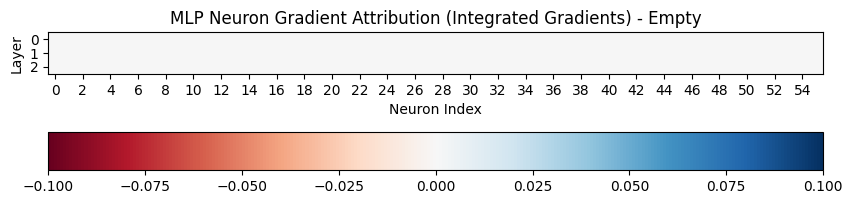

In [56]:
bound = max(torch.max(mlp_ig_empty_results), abs(torch.min(mlp_ig_empty_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_ig_empty_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients) - Empty")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

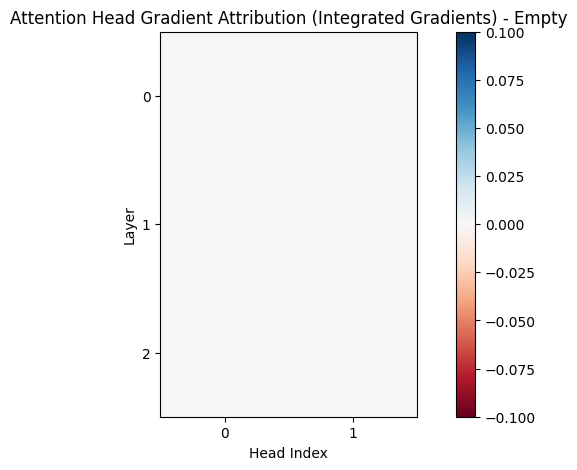

In [57]:
bound = max(torch.max(attn_ig_empty_results), abs(torch.min(attn_ig_empty_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_empty_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients) - Empty")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

### Average of Integrated Gradients attributions

*Observation*: The activation patching attribution scores look like they could be the average of the integrated gradients attribution scores for the clean and corrupted inputs.

*Aim*: Take the average of the integrated gradients scores for balanced and unbalanced inputs. 

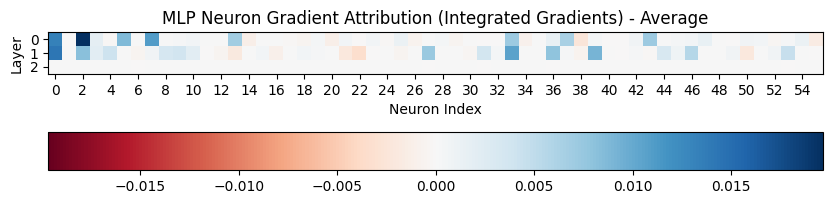

In [58]:
mlp_ig_sum_results = (mlp_ig_results + mlp_ig_unbalanced_results) / 2

bound = max(torch.max(mlp_ig_sum_results), abs(torch.min(mlp_ig_sum_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_ig_sum_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients) - Average")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

The average of IG attribution scores is somewhat noisier.

# Factors which impact Activation Patching

### Patching with different inputs

*Hypothesis*: Activation patching could be sensitive to the pair of inputs used for corruption.

In [60]:
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.hook_points import HookPoint

clean_tokens_v2 = "()()"
corrupted_tokens_v2 = "))()"

clean_input_v2 = tokenizer.tokenize(clean_tokens_v2)        # Balanced
corrupted_input_v2 = tokenizer.tokenize(corrupted_tokens_v2)    # Unbalanced

# We run on the corrupted prompt with the cache so we store activations to patch in later.
corrupted_logits_v2, corrupted_cache_v2 = model.run_with_cache(corrupted_input_v2)
clean_logits_v2 = model(clean_input_v2)

# Get probability of overall sequence being balanced (class 1) from position 0
clean_answer_logits_v2 = clean_logits_v2[0, 0, 1]
corrupted_answer_logits_v2 = corrupted_logits_v2[0, 0, 1]
print(f"Balanced input score: {clean_answer_logits_v2}")
print(f"Unbalanced input score: {corrupted_answer_logits_v2}")

baseline_diff_v2 = (corrupted_answer_logits_v2 - clean_answer_logits_v2).item()
print(f"Baseline clean-corrupted logit difference: {baseline_diff_v2:.2f}")

# Patch neurons in MLP layers
mlp_patch_results_v2 = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Patch attention heads
attn_patch_results_v2 = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

for layer in range(model.cfg.n_layers):
    # Activation patching on heads
    for head in range(model.cfg.n_heads):
        hook_name = get_act_name("result", layer)
        temp_hook = lambda act, hook: patch_attn_hook(act, hook, corrupted_cache_v2, head)

        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_input_v2)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - clean_answer_logits_v2).item()
        # Normalise result by clean and corrupted logit difference
        attn_patch_results_v2[layer, head] = logit_diff / baseline_diff_v2

    # Activation patching on MLP neurons
    for neuron in range(model.cfg.d_mlp):
        hook_name = get_act_name("post", layer)
        temp_hook = lambda act, hook: patch_neuron_hook(act, hook, corrupted_cache_v2, neuron)
        
        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_input_v2)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - clean_answer_logits_v2).item()
        # Normalise result by clean and corrupted logit difference
        mlp_patch_results_v2[layer, neuron] = logit_diff / baseline_diff_v2

Balanced input score: 5.693811416625977
Unbalanced input score: -4.950194358825684
Baseline clean-corrupted logit difference: -10.64


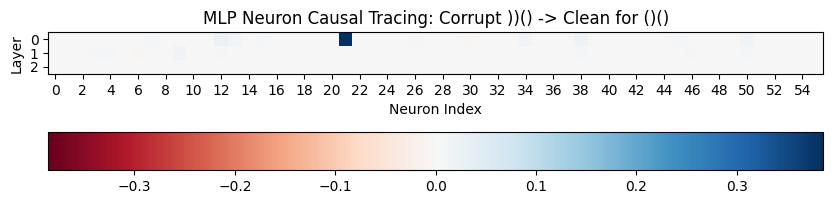

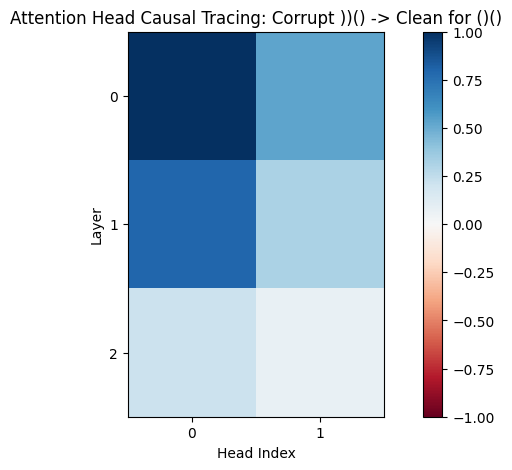

In [61]:
bound = max(torch.max(mlp_patch_results_v2), abs(torch.min(mlp_patch_results_v2)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_patch_results_v2, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title(f"MLP Neuron Causal Tracing: Corrupt {corrupted_tokens_v2} -> Clean for {clean_tokens_v2}")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

bound = max(torch.max(attn_patch_results_v2), abs(torch.min(attn_patch_results_v2)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_patch_results_v2, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title(f"Attention Head Causal Tracing: Corrupt {corrupted_tokens_v2} -> Clean for {clean_tokens_v2}")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

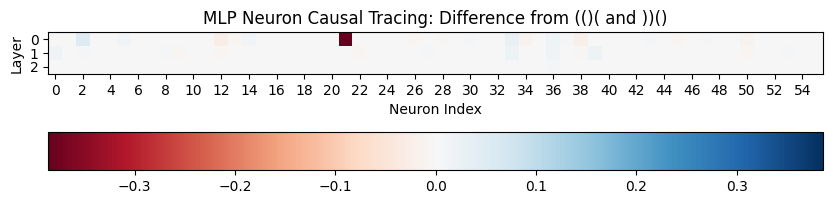

In [62]:
# Compare difference with alternative inputs

mlp_patch_diff = mlp_patch_results - mlp_patch_results_v2

bound = max(torch.max(mlp_patch_diff), abs(torch.min(mlp_patch_diff)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_patch_diff, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title(f"MLP Neuron Causal Tracing: Difference from (()( and ))()")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

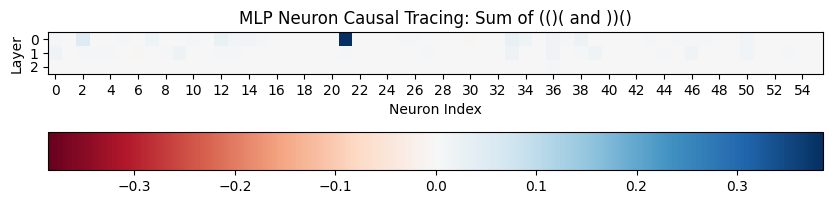

In [63]:
# Combine alternative inputs

mlp_patch_sum = mlp_patch_results + mlp_patch_results_v2

bound = max(torch.max(mlp_patch_sum), abs(torch.min(mlp_patch_sum)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_patch_sum, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title(f"MLP Neuron Causal Tracing: Sum of (()( and ))()")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

### Patching in the opposite direction (denoising)

*Hypothesis*: activation patching is sensitive to the direction of patching. Patching from clean to corrupted activations should reveal sufficient components to restore model behaviour.

In [64]:
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.hook_points import HookPoint

clean_input = tokenizer.tokenize("()()")        # Balanced
corrupted_input = tokenizer.tokenize("(()(")    # Unbalanced

# We run on the clean prompt with the cache so we store activations to patch in later.
clean_logits, clean_cache = model.run_with_cache(clean_input)
corrupted_logits = model(corrupted_input)

# Get probability of overall sequence being balanced (class 1) from position 0
clean_answer_logits = clean_logits[0, 0, 1]
corrupted_answer_logits = corrupted_logits[0, 0, 1]
print(f"Balanced input score: {clean_answer_logits}")
print(f"Unbalanced input score: {corrupted_answer_logits}")

baseline_diff = (corrupted_answer_logits - clean_answer_logits).item()
print(f"Baseline clean-corrupted logit difference: {baseline_diff:.2f}")

Balanced input score: 5.693811416625977
Unbalanced input score: -5.421151161193848
Baseline clean-corrupted logit difference: -11.11


In [65]:
# Patch neurons in MLP layers
mlp_patch_denoising_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Patch attention heads
attn_patch_denoising_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

for layer in range(model.cfg.n_layers):
    # Activation patching on heads
    for head in range(model.cfg.n_heads):
        hook_name = get_act_name("result", layer)
        temp_hook = lambda act, hook: patch_attn_hook(act, hook, clean_cache, head)

        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(corrupted_input)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - corrupted_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        attn_patch_denoising_results[layer, head] = logit_diff / baseline_diff

    # Activation patching on MLP neurons
    for neuron in range(model.cfg.d_mlp):
        hook_name = get_act_name("post", layer)
        temp_hook = lambda act, hook: patch_neuron_hook(act, hook, clean_cache, neuron)
        
        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(corrupted_input)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - corrupted_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        mlp_patch_denoising_results[layer, neuron] = logit_diff / baseline_diff

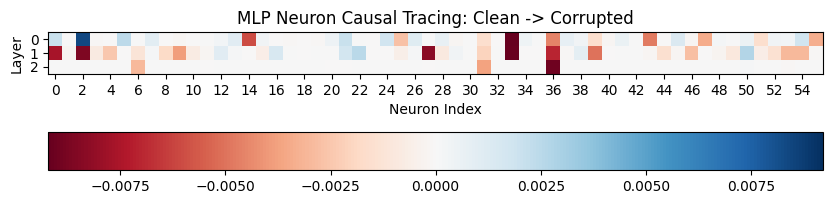

In [66]:
bound = max(torch.max(mlp_patch_denoising_results), abs(torch.min(mlp_patch_denoising_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_patch_denoising_results, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Causal Tracing: Clean -> Corrupted")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

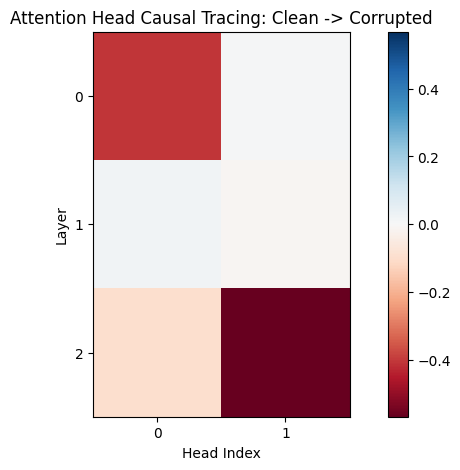

In [67]:
bound = max(torch.max(attn_patch_denoising_results), abs(torch.min(attn_patch_denoising_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_patch_denoising_results, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Causal Tracing: Clean -> Corrupted")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

Patching in the opposite direction highlights similar components to original activation patching. May be possible to get both necessary and sufficient components by patching in both directions, although this is expensive.

# Distribution of activations and baselines

*Hypothesis*: One possible reason for the discrepancy between patching and IG is that the range of activations tested may be from different distributions.

Both gradient methods rely on counterfactual reasoning. IG computes the integral between some baseline (which produces zero output) and given input, whereas causal tracing computes the logit difference between two counterfactual inputs. If the counterfactuals used are different, then this could cause a discrepancy.

I plotted the maximum difference between the corrupted activations and the range of zero to clean activations. The plot indicates that the corrupt activations for many MLP neurons lie outside of the range, suggesting that there could be out-of-distribution issues going on.

In [69]:
# If the corrupt activations for tracing are outside of the bounds for gradient attribution, measure the distance

def measure_distance_from_bound(bounds, value):
    lower_bound = min(bounds)
    upper_bound = max(bounds)
    if value < lower_bound:
        return value - lower_bound
    if value > upper_bound:
        return value - upper_bound
    return 0

clean_input = tokenizer.tokenize("()()")        # Balanced
corrupted_input = tokenizer.tokenize("(()(")    # Unbalanced

clean_logits, clean_cache = model.run_with_cache(clean_input)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_input)

mlp_distance = torch.zeros((model.cfg.n_layers, model.cfg.d_mlp))
attn_distance = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))


for layer in range(model.cfg.n_layers):
    # Get distance for attention heads
    hook_name = get_act_name("result", layer)
    layer_corrupt_acts = corrupted_cache[hook_name]
    layer_clean_acts = clean_cache[hook_name]
    # Go over each attention head and take the maximum distance
    for head in range(model.cfg.n_heads):
        head_corrupt_acts = layer_corrupt_acts.max(dim=3)[0].max(dim=1)[0][0, head]
        head_clean_acts = layer_clean_acts.mean(dim=3).mean(dim=1)[0, head]
        # The clean activations are what is used for integrated gradients
        distance = measure_distance_from_bound(bounds=(0, head_clean_acts), value=head_corrupt_acts)
        attn_distance[layer, head] = distance

    # Get distance for MLP neurons
    hook_name = get_act_name("post", layer)
    layer_corrupt_acts = corrupted_cache[hook_name]
    layer_clean_acts = clean_cache[hook_name]
    for neuron_idx in range(model.cfg.d_mlp):
        neuron_corrupt_acts = layer_corrupt_acts[0, :, neuron_idx]
        neuron_clean_acts = layer_clean_acts[0, :, neuron_idx]
        # Go over each token and take the maximum distance
        max_distance = 0
        for i in range(neuron_clean_acts.size(-1)):
            # The clean activations are what is used for integrated gradients
            distance = measure_distance_from_bound(bounds=(0, neuron_clean_acts[i]), value=neuron_corrupt_acts[i])
            max_distance = max(distance, max_distance)
        mlp_distance[layer, neuron_idx] = max_distance

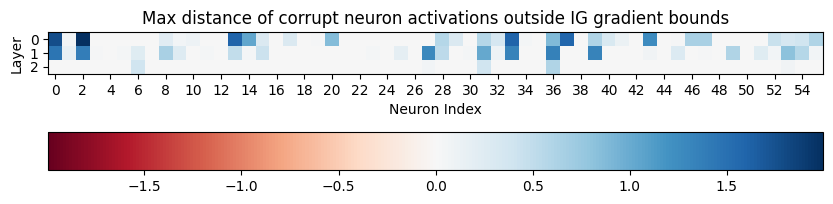

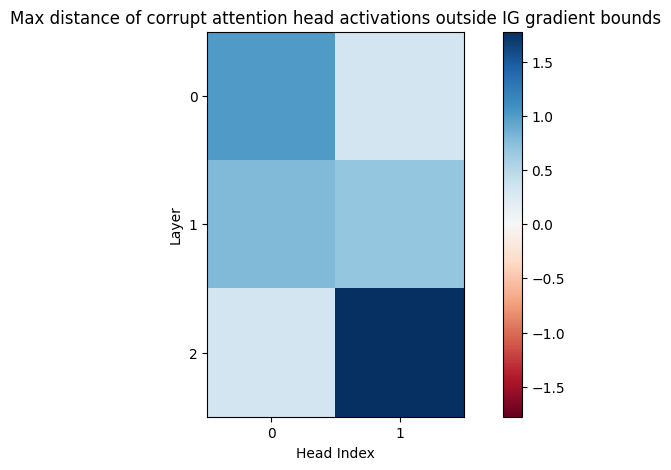

In [70]:
bound = max(torch.max(mlp_distance), abs(torch.min(mlp_distance)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_distance.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Max distance of corrupt neuron activations outside IG gradient bounds")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

bound = max(torch.max(attn_distance), abs(torch.min(attn_distance)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_distance, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Max distance of corrupt attention head activations outside IG gradient bounds")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

Qualitatively, for MLP neurons, the corrupt activations are outside of the range of zero to clean activations in areas highlighted by both methods. For attention heads, most of the corrupt attention head activations seem to be outside of IG bounds.

### Baseline as corrupted activations

Instead of using zero as the baseline activation, use the activation from the corrupt input in causal tracing.

In [71]:
# Gradient attribution for neurons in MLP layers
mlp_ig_corrupt_baseline_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Gradient attribution for attention heads
attn_ig_corrupt_baseline_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
clean_input = tokenizer.tokenize("()()")
_, clean_cache = model.run_with_cache(clean_input)

corrupted_input = tokenizer.tokenize("(()(")
# mask = np.isin(input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
# corrupted_input = input * mask + tokenizer.PAD_TOKEN * (1 - mask)
_, corrupted_cache = model.run_with_cache(corrupted_input)

for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("z", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = corrupted_cache[prev_layer_hook]

    print(run_from_layer_fn(layer_corrupt_input, clean_input, prev_layer))

    attributions = compute_layer_to_output_attributions(clean_input, layer_clean_input, layer_corrupt_input, target_layer, prev_layer) # shape [1, seq_len, d_head, d_model]
    # Calculate attribution score based on mean over each embedding, for each token
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_corrupt_baseline_results[layer] = score

    # Gradient attribution on MLP neurons
    hook_name = get_act_name("post", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("mlp_in", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = corrupted_cache[prev_layer_hook]
    
    attributions = compute_layer_to_output_attributions(clean_input, layer_clean_input, layer_corrupt_input, target_layer, prev_layer) # shape [1, seq_len, d_model]
    score = attributions.mean(dim=1)
    mlp_ig_corrupt_baseline_results[layer] = score

tensor([1.4471e-05], grad_fn=<SelectBackward0>)

Error (delta) for blocks.0.attn.hook_result attribution: -0.5329379439353943

Error (delta) for blocks.0.mlp.hook_post attribution: -0.01021033525466919
tensor([0.0496], grad_fn=<SelectBackward0>)

Error (delta) for blocks.1.attn.hook_result attribution: -0.00025922060012817383

Error (delta) for blocks.1.mlp.hook_post attribution: 2.1576881408691406e-05
tensor([8.8178e-06], grad_fn=<SelectBackward0>)

Error (delta) for blocks.2.attn.hook_result attribution: -0.00015395879745483398

Error (delta) for blocks.2.mlp.hook_post attribution: 2.035494617302902e-08


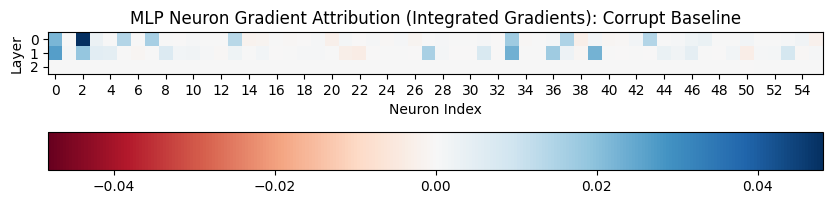

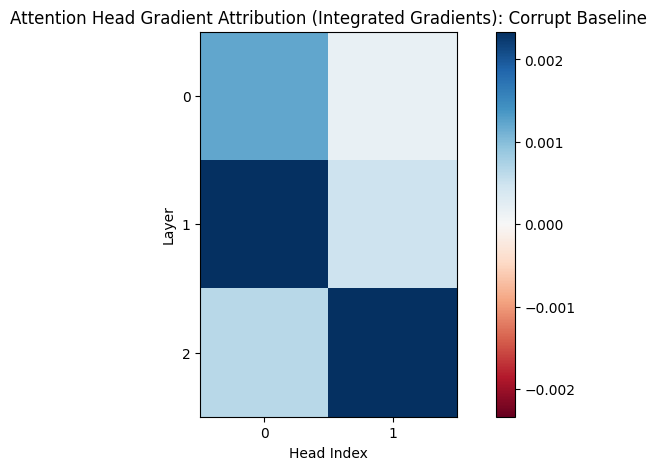

In [72]:
bound = max(torch.max(mlp_ig_corrupt_baseline_results), abs(torch.min(mlp_ig_corrupt_baseline_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_ig_corrupt_baseline_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients): Corrupt Baseline")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

bound = max(torch.max(attn_ig_corrupt_baseline_results), abs(torch.min(attn_ig_corrupt_baseline_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_corrupt_baseline_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients): Corrupt Baseline")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

Running integrated gradients with the baselines as the corrupt activations seems to bring results closer to causal tracing for MLP neurons, but further away for attention heads. The MLP neuron attribution scores still have minor disagreements.

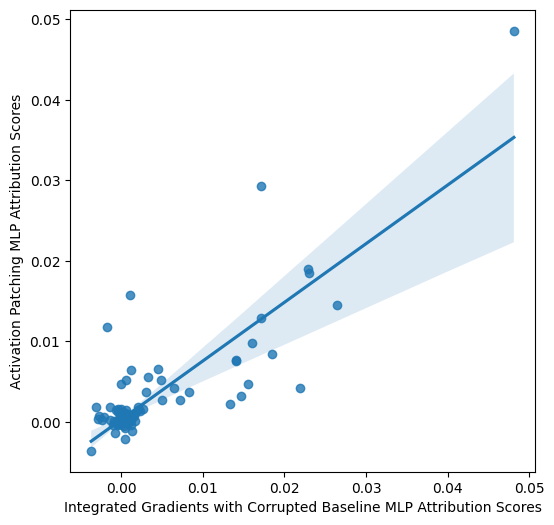

Correlation coefficient between IG with corrupted baseline and AP attributions for neurons: 0.8414242401628172


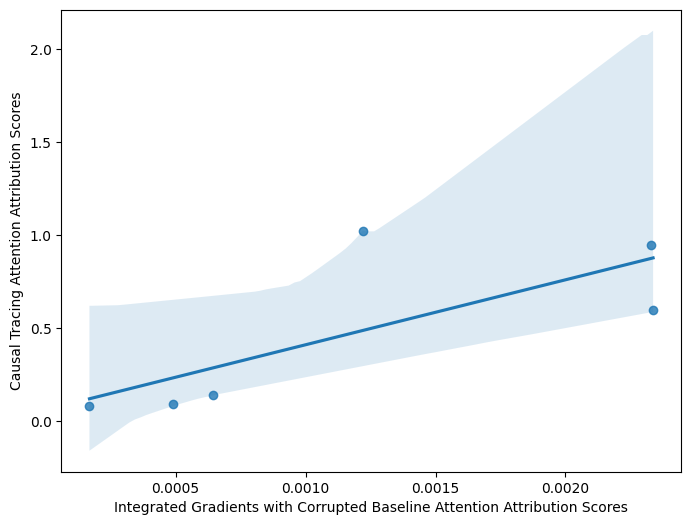

Correlation coefficient between IG with corrupted baseline and AP attributions for attention: 0.7527591889268093


In [73]:
# Plot the attribution scores against each other. Correlation: y = x.

x = mlp_ig_corrupt_baseline_results.flatten().numpy()
y = mlp_patch_results.flatten().numpy()

plt.figure(figsize=(6,6))
sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients with Corrupted Baseline MLP Attribution Scores")
plt.ylabel("Activation Patching MLP Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG with corrupted baseline and AP attributions for neurons: {np.corrcoef(x, y)[0, 1]}")

x = attn_ig_corrupt_baseline_results.flatten().numpy()
y = attn_patch_results.flatten().numpy()

plt.figure(figsize=(8,6))
sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients with Corrupted Baseline Attention Attribution Scores")
plt.ylabel("Causal Tracing Attention Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG with corrupted baseline and AP attributions for attention: {np.corrcoef(x, y)[0, 1]}")

In [74]:
top_mlp_corrupt_baseline_ig_indices, _ = get_attributions_above_threshold(mlp_ig_corrupt_baseline_results, 0.3)

top_mlp_corrupt_baseline_ig_sets = set([tuple(t.tolist()) for t in top_mlp_corrupt_baseline_ig_indices])
top_mlp_patch_sets = set([tuple(t.tolist()) for t in top_mlp_patch_indices])

intersection = top_mlp_corrupt_baseline_ig_sets.intersection(top_mlp_patch_sets)
union = top_mlp_corrupt_baseline_ig_sets.union(top_mlp_patch_sets)
jaccard = len(intersection) / len(union)

print(f"Jaccard score for MLP neurons using IG with corrupted baseline: {jaccard}")

Jaccard score for MLP neurons using IG with corrupted baseline: 0.4666666666666667


### Activation patching with IG zero baseline

Instead of patching in activation from unbalanced input, patch in zero ablation (same baseline as integrated gradients).

In [75]:
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.hook_points import HookPoint
from collections import defaultdict

clean_input = tokenizer.tokenize("()()")        # Balanced
clean_logits = model(clean_input)
clean_answer_logits = clean_logits[0, 0, 1]

zero_attn_cache = defaultdict(lambda: torch.zeros((1, 1, model.cfg.n_heads, 1))) # Return zero for any attention head
zero_mlp_cache = defaultdict(lambda: torch.zeros((1, 1, model.cfg.d_mlp))) # Return zero for any MLP neuron

In [76]:
# Patch neurons in MLP layers
mlp_patch_zero_baseline_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Patch attention heads
attn_patch_zero_baseline_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

for layer in range(model.cfg.n_layers):
    # Activation patching on heads
    for head in range(model.cfg.n_heads):
        hook_name = get_act_name("result", layer)
        temp_hook = lambda act, hook: patch_attn_hook(act, hook, zero_attn_cache, head)

        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_input)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - clean_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        attn_patch_zero_baseline_results[layer, head] = logit_diff

    # Activation patching on MLP neurons
    for neuron in range(model.cfg.d_mlp):
        hook_name = get_act_name("post", layer)
        temp_hook = lambda act, hook: patch_neuron_hook(act, hook, zero_mlp_cache, neuron)
        
        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_input)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - clean_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        mlp_patch_zero_baseline_results[layer, neuron] = logit_diff

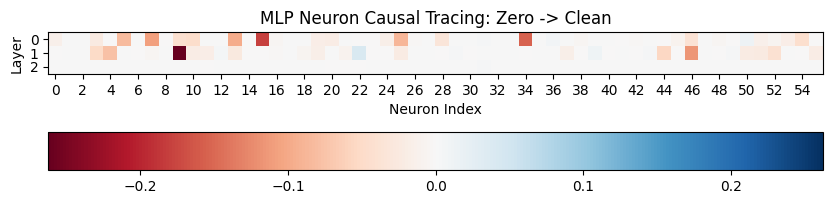

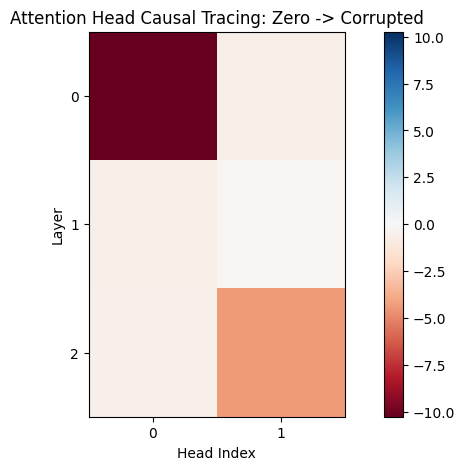

In [77]:
bound = max(torch.max(mlp_patch_zero_baseline_results), abs(torch.min(mlp_patch_zero_baseline_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_patch_zero_baseline_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Causal Tracing: Zero -> Clean")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

bound = max(torch.max(attn_patch_zero_baseline_results), abs(torch.min(attn_patch_zero_baseline_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_patch_zero_baseline_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Causal Tracing: Zero -> Corrupted")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

Performing causal tracing by ablating the components with zero activations produces a very different attribution score distribution. This might not be meaningful since zero ablations are most likely out-of-distribution wrt the model’s typical activation patterns.

### Patching with mean value of corrupted dataset

In [78]:
import json
from toy_transformers.brackets_datasets import BracketsDataset

# Get corrupted datasets
with open("toy_transformers/brackets_data.json") as f:
    data_tuples = json.load(f)
    data_tuples = data_tuples[:5000]
    data = BracketsDataset(data_tuples)

corrupted_dataset = data.toks[~data.isbal]
corrupted_dataset_answer_logits, corrupted_dataset_cache = model.run_with_cache(corrupted_dataset)

In [79]:
def patch_mean_neuron_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, neuron_idx: int):
    # Replace the activations for the target neuron with activations from the cached run.
    cached_activations = cache[hook.name].mean(dim=0)
    activations[:, :, neuron_idx] = cached_activations[:, neuron_idx]
    return activations

def patch_mean_attn_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, head_idx: int):
    # Replace the activations for the target attention head with activations from the cached run.
    cached_activations = cache[hook.name].mean(dim=0)
    activations[:, :, head_idx, :] = cached_activations[:, head_idx, :]
    return activations

In [80]:
clean_input = tokenizer.tokenize("()()")
# Pad token size to match corrupted_dataset size
padding = torch.full((1, model.cfg.n_ctx - clean_input.size(1)), tokenizer.PAD_TOKEN)
print(clean_input.shape, padding.shape)
clean_input = torch.cat([clean_input, padding], dim=-1)
print(clean_input.shape)

clean_logits = model(clean_input)
clean_answer_logits = clean_logits[0, 0, 1]
corrupted_dataset_answer_logits = corrupted_dataset_answer_logits.mean(dim=0)
baseline_mean_diff = (corrupted_answer_logits - clean_answer_logits).item()

# Patch neurons in MLP layers
mlp_patch_mean_corrupt_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Patch attention heads
attn_patch_mean_corrupt_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

for layer in range(model.cfg.n_layers):
    # Activation patching on heads
    for head in range(model.cfg.n_heads):
        hook_name = get_act_name("result", layer)
        temp_hook = lambda act, hook: patch_mean_attn_hook(act, hook, corrupted_dataset_cache, head)

        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_input)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - clean_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        attn_patch_mean_corrupt_results[layer, head] = logit_diff / baseline_mean_diff

    # Activation patching on MLP neurons
    for neuron in range(model.cfg.d_mlp):
        hook_name = get_act_name("post", layer)
        temp_hook = lambda act, hook: patch_mean_neuron_hook(act, hook, corrupted_dataset_cache, neuron)
        
        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(clean_input)

        patched_answer_logits = patched_logits[0, 0, 1]
        logit_diff = (patched_answer_logits - clean_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        mlp_patch_mean_corrupt_results[layer, neuron] = logit_diff / baseline_mean_diff

torch.Size([1, 6]) torch.Size([1, 36])
torch.Size([1, 42])


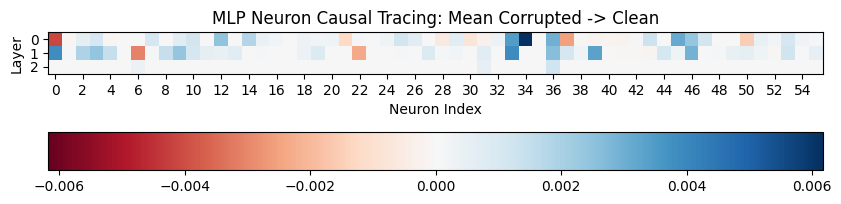

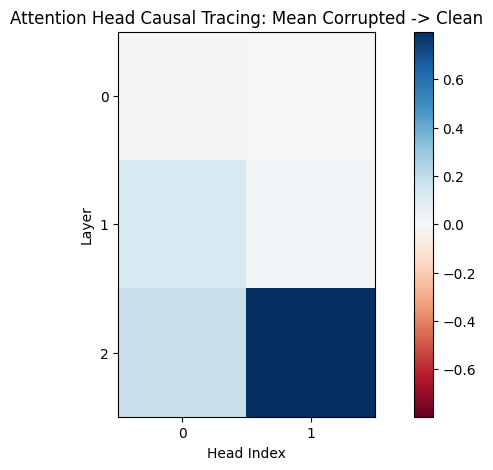

In [81]:
bound = max(torch.max(mlp_patch_mean_corrupt_results), abs(torch.min(mlp_patch_mean_corrupt_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_patch_mean_corrupt_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Causal Tracing: Mean Corrupted -> Clean")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

bound = max(torch.max(attn_patch_mean_corrupt_results), abs(torch.min(attn_patch_mean_corrupt_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_patch_mean_corrupt_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Causal Tracing: Mean Corrupted -> Clean")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

I performed casual tracing by ablating components with the mean activation for a dataset of corrupted outputs. The attribution results look different from existing IG and causal tracing results with the corrupt baseline `(()(`. This is the sharpest attribution result so far - could potentially be the most generalisable?

# Ablation studies

We evaluate the discrepancy between the two methods using ablation studies, to investigate possible causes of the different attributions.

In [82]:
import json
from toy_transformers.brackets_datasets import BracketsDataset
from toy_transformers.toy_bracket_transformer import test_loaded_bracket_model_on_dataset


# Get clean and corrupted datasets
with open("toy_transformers/brackets_data.json") as f:
    data_tuples = json.load(f)
    data_tuples = data_tuples[:6000]
    data = BracketsDataset(data_tuples)

clean_dataset = data.toks[data.isbal]
clean_is_balanced = torch.ones(clean_dataset.size(0))
corrupted_dataset = data.toks[~data.isbal]
corrupted_is_balanced = torch.zeros(corrupted_dataset.size(0))

_, corrupted_dataset_cache = model.run_with_cache(corrupted_dataset)


In [83]:
# Evaluate baseline performance on sample dataset

baseline_logits, baseline_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
print("Original model performance on positive samples:", baseline_performance.item())


Model got 2732 out of 2732 training examples correct!
Original model performance on positive samples: 1.0


In [84]:
_, baseline_corrupted_performance = test_loaded_bracket_model_on_dataset(model, corrupted_dataset, corrupted_is_balanced)
print("Original model performance on negative samples:", baseline_corrupted_performance.item())


Model got 3268 out of 3268 training examples correct!
Original model performance on negative samples: 1.0


In [85]:
def ablate_neuron_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, set_neurons_to_keep: set):
    cached_activations = cache[hook.name].mean(dim=0) # Replace with mean value of activation samples
    n_neurons = activations.shape[2]
    layer = hook.layer()
    for idx in range(n_neurons):
        if (layer, idx) not in set_neurons_to_keep:
            activations[:, :, idx] = cached_activations[:, idx]
    return activations

def ablate_attn_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, set_heads_to_keep: set):
    cached_activations = cache[hook.name].mean(dim=0)
    n_heads = activations.shape[2]
    layer = hook.layer()
    for head_idx in range(n_heads):
        if (layer, head_idx) not in set_heads_to_keep:
            activations[:, :, head_idx, :] = cached_activations[:, head_idx, :]
    return activations

In [86]:
# Baseline comparison: ablating all MLP neurons and attention heads

model_ablate_all_hooks = []
for layer in range(model.cfg.n_layers):
    mlp_hook_point = get_act_name("post", layer)
    model_ablate_all_hooks.append((mlp_hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set())))

    attn_hook_point = get_act_name("result", layer)
    model_ablate_all_hooks.append((attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set())))

with model.hooks(fwd_hooks=model_ablate_all_hooks):
    _, model_ablate_all_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print("Performance when ablating all MLP neurons and attention heads:", model_ablate_all_performance.item())


Model got 0 out of 2732 training examples correct!
Performance when ablating all MLP neurons and attention heads: 0.0


In [87]:
# Baseline comparison: ablating all MLP neurons

mlp_ablate_all_hooks = []
for layer in range(model.cfg.n_layers):
    hook_point = get_act_name("post", layer)
    mlp_ablate_all_hooks.append((hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set())))

with model.hooks(fwd_hooks=mlp_ablate_all_hooks):
    _, mlp_ablate_all_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print("Performance when ablating all MLP neurons:", mlp_ablate_all_performance.item())



Model got 0 out of 2732 training examples correct!
Performance when ablating all MLP neurons: 0.0


In [88]:
# Baseline comparison: ablating all attention heads

attn_ablate_all_hooks = []
for layer in range(model.cfg.n_layers):
    attn_hook_point = get_act_name("result", layer)
    attn_ablate_all_hooks.append((attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set())))

with model.hooks(fwd_hooks=attn_ablate_all_hooks):
    _, attn_ablate_all_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print("Performance when ablating all attention heads:", attn_ablate_all_performance)


Model got 0 out of 2732 training examples correct!
Performance when ablating all attention heads: tensor(0.)


### Ablation studies for integrated gradients

Evaluate faithfulness: when "unimportant" neurons and attention heads are ablated, performance should not be affected.

In [89]:
# Evaluate faithfulness: when "unimportant" neurons and attention heads are ablated, performance should not be affected

ig_isolation_hooks = []
set_top_mlp_ig_indices = set([tuple(t.tolist()) for t in top_mlp_ig_indices])
print(f"Neurons to keep: {len(set_top_mlp_ig_indices)} out of {model.cfg.n_layers * model.cfg.d_mlp}")

set_ig_heads = set([(0,0), (1,0), (2,0), (2,1)])

for layer in range(model.cfg.n_layers):
    mlp_hook_point = get_act_name("post", layer)
    ig_isolation_hooks.append((mlp_hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set_top_mlp_ig_indices)))

    attn_hook_point = get_act_name("result", layer)
    ig_isolation_hooks.append((attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set_ig_heads)))

with model.hooks(fwd_hooks=ig_isolation_hooks):
    ig_isolated_logits, ig_isolated_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print(ig_isolated_performance)


Neurons to keep: 30 out of 168

Model got 2300 out of 2732 training examples correct!
tensor(0.8419)


Evaluate completeness: when "important" neurons are ablated, performance should be affected.

In [90]:
# Get neurons to keep: complementary to neurons to keep

def get_complementary_neuron_indices(neuron_indices: torch.Tensor, mlp_shape: tuple):
    mask = torch.ones(mlp_shape)
    for idx in neuron_indices:
        layer_idx, neuron_idx = tuple(idx)
        if layer_idx < mlp_shape[0] and neuron_idx < mlp_shape[1]:
            mask[layer_idx, neuron_idx] = 0.0
    complementary_indices = torch.nonzero(mask)
    return complementary_indices

# Evaluate completeness: when "important" neurons are ablated, performance should be affected

mlp_ig_excluded_indices = get_complementary_neuron_indices(top_mlp_ig_indices, (model.cfg.n_layers, model.cfg.d_mlp))
set_mlp_ig_excluded_indices = set([tuple(t.tolist()) for t in mlp_ig_excluded_indices])
print(f"Neurons to keep: {len(set_mlp_ig_excluded_indices)} out of {model.cfg.n_layers * model.cfg.d_mlp}")

set_ig_excluded_heads = [(0,1), (1,1)]

ig_ablation_hooks = []
for layer in range(model.cfg.n_layers):
    hook_point = get_act_name("post", layer)
    ig_ablation_hooks.append((hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set_neurons_to_keep=set_mlp_ig_excluded_indices)))

    attn_hook_point = get_act_name("result", layer)
    ig_ablation_hooks.append((attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set_ig_excluded_heads)))


with model.hooks(fwd_hooks=ig_ablation_hooks):
    _, ig_ablated_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print(ig_ablated_performance)

Neurons to keep: 138 out of 168

Model got 0 out of 2732 training examples correct!
tensor(0.)


### Ablation studies on causal tracing

Evaluate faithfulness: when "unimportant" neurons and attention heads are ablated, performance should not be affected


In [91]:
# Evaluate faithfulness: when "unimportant" neurons and attention heads are ablated, performance should not be affected

patch_isolation_hooks = []
set_top_mlp_patch_indices = set([tuple(t.tolist()) for t in top_mlp_patch_indices])
print(f"Neurons to keep: {len(set_top_mlp_patch_indices)} out of {model.cfg.n_layers * model.cfg.d_mlp}")

set_patch_heads = set([(0,0), (1,0), (2,0), (2,1)])

for layer in range(model.cfg.n_layers):
    mlp_hook_point = get_act_name("post", layer)
    patch_isolation_hooks.append((mlp_hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set_top_mlp_patch_indices)))

    attn_hook_point = get_act_name("result", layer)
    patch_isolation_hooks.append((attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set_patch_heads)))

with model.hooks(fwd_hooks=patch_isolation_hooks):
    patch_isolated_logits, patch_isolated_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print(patch_isolated_performance)


Neurons to keep: 30 out of 168

Model got 2147 out of 2732 training examples correct!
tensor(0.7859)


Evaluate completeness: when "important" neurons are ablated, performance should be affected

In [92]:
# Evaluate completeness: when "important" neurons are ablated, performance should be affected

patch_ig_excluded_indices = get_complementary_neuron_indices(top_mlp_patch_indices, (model.cfg.n_layers, model.cfg.d_mlp))
set_mlp_patch_excluded_indices = set([tuple(t.tolist()) for t in patch_ig_excluded_indices])
print(f"Neurons to keep: {len(set_mlp_patch_excluded_indices)} out of {model.cfg.n_layers * model.cfg.d_mlp}")

set_patch_excluded_heads = [(0,1), (1,1)]

patch_ablation_hooks = []
for layer in range(model.cfg.n_layers):
    hook_point = get_act_name("post", layer)
    patch_ablation_hooks.append((hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set_neurons_to_keep=set_mlp_patch_excluded_indices)))

    attn_hook_point = get_act_name("result", layer)
    patch_ablation_hooks.append((attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set_patch_excluded_heads)))


with model.hooks(fwd_hooks=patch_ablation_hooks):
    _, patch_ablated_performance = test_loaded_bracket_model_on_dataset(model, clean_dataset, clean_is_balanced)
    print(patch_ablated_performance)

Neurons to keep: 138 out of 168

Model got 0 out of 2732 training examples correct!
tensor(0.)


### Analysis of ablation studies

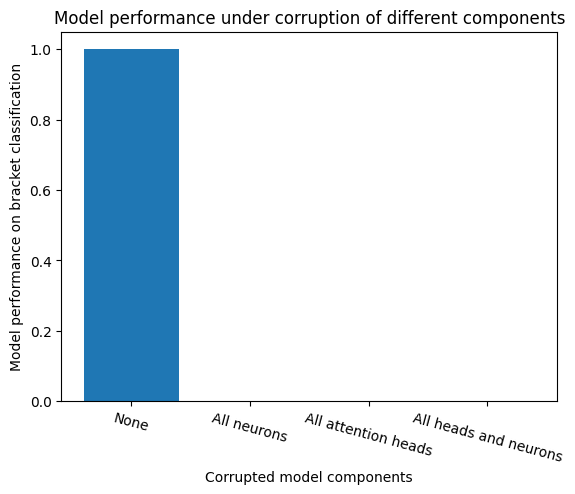

In [93]:
plt.title("Model performance under corruption of different components")
plt.xlabel("Corrupted model components")
plt.ylabel("Model performance on bracket classification")
plt.bar(
    ["None", "All neurons", "All attention heads", "All heads and neurons"],
    [baseline_performance, mlp_ablate_all_performance, attn_ablate_all_performance, model_ablate_all_performance]
)
plt.xticks(rotation=-15)
plt.show()

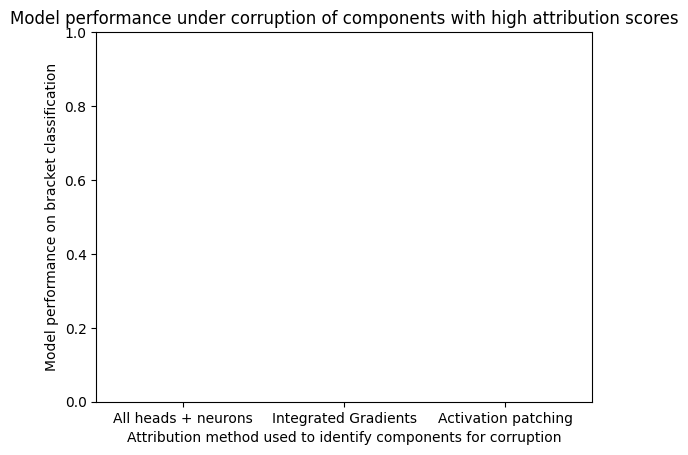

In [94]:
plt.title("Model performance under corruption of components with high attribution scores")
plt.xlabel("Attribution method used to identify components for corruption")
plt.ylabel("Model performance on bracket classification")
plt.bar(
    ["All heads + neurons", "Integrated Gradients", "Activation patching"],
    [model_ablate_all_performance, ig_ablated_performance, patch_ablated_performance],
    color=['grey', 'tab:blue', 'tab:blue']
)
plt.ylim(0, 1)
plt.show()

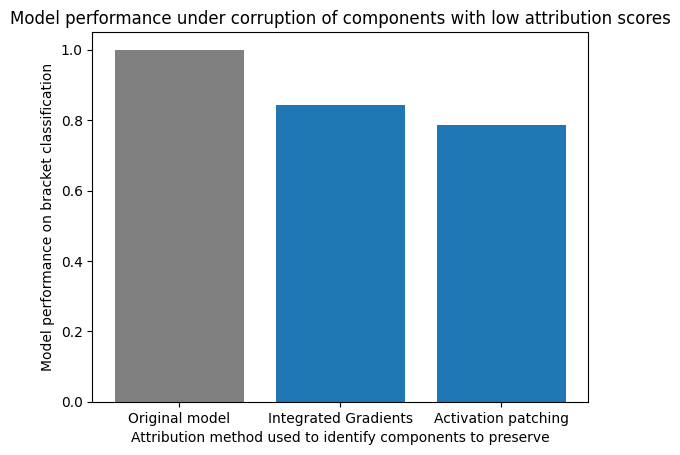

In [95]:
plt.title("Model performance under corruption of components with low attribution scores")
plt.xlabel("Attribution method used to identify components to preserve")
plt.ylabel("Model performance on bracket classification")
plt.bar(
    ["Original model", "Integrated Gradients", "Activation patching"],
    [baseline_performance, ig_isolated_performance, patch_isolated_performance],
    color=['grey', 'tab:blue', 'tab:blue']
)
plt.show()

Preliminary ablation studies show that integrated gradients and activation patching both find important circuit components, as corrupting identified components reduces performance to 0.

However, activation patching may identify an over-complete circuit. For activation patching, corrupting all components *outside* of the identified neurons and attention heads reduces performance more than integrated gradients.

- One explanation is that activation patching only picks up components which are important to the specific circuit under examination, whereas integrated gradients identifies components which are overall important to the model.
- Another explanation (more likely) is that the dataset used for evaluations is small, and minor differences in performance are not significant.

# Gradual ablation

Instead of taking the top 20% components and corrupting them all, we gradually corrupt components from the lowest attribution scores first to the highest attribution scores, and measure the drop in performance.

### Gradual ablation for Integrated Gradients

In [ ]:
# Order MLP neurons and attention heads by ABSOLUTE attribution scores

combined_ig_results = torch.concat([mlp_ig_results.flatten(), attn_ig_results.flatten()])
sorted_indices_1d = torch.argsort(combined_ig_results.abs())

NEURON_LABEL, ATTN_LABEL = 0, 1

def convert_1d_indices_to_2d(indices_1d):
    indices_2d = []
    max_mlp_index = model.cfg.d_mlp * model.cfg.n_layers
    for idx in indices_1d:
        if idx < max_mlp_index:
            # MLP neuron
            layer = idx // model.cfg.d_mlp
            neuron_pos = idx % model.cfg.d_mlp
            indices_2d.append([NEURON_LABEL, layer.item(), neuron_pos.item()])
        else:
            # Attention
            attn_idx = idx - (model.cfg.d_mlp * model.cfg.n_layers)
            layer = attn_idx // model.cfg.n_heads
            attn_head_pos = attn_idx % model.cfg.n_heads
            indices_2d.append([ATTN_LABEL, layer.item(), attn_head_pos.item()])
    return indices_2d

sorted_indices_2d = convert_1d_indices_to_2d(sorted_indices_1d)

In [ ]:
#| output: false

# Gradually corrupt components with lowest attribution scores

gradual_ig_corruption_performance = []

# Preserve all neurons at first, then delete
set_gradual_neurons_to_keep = set([(layer, pos) for layer in range(model.cfg.n_layers) for pos in range(model.cfg.d_mlp)])
set_gradual_attn_to_keep = set([(layer, pos) for layer in range(model.cfg.n_layers) for pos in range(model.cfg.n_heads)])

model.clear_contexts()
model.remove_all_hook_fns()

for idx in range(len(sorted_indices_2d)):
    keep_type, keep_layer, keep_idx = sorted_indices_2d[idx]
    if keep_type == NEURON_LABEL:
        set_gradual_neurons_to_keep.remove((keep_layer, keep_idx))
        mlp_hook_point = get_act_name("post", keep_layer)
        model.add_hook(mlp_hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set_gradual_neurons_to_keep.copy()))
    else:
        set_gradual_attn_to_keep.remove((keep_layer, keep_idx))
        attn_hook_point = get_act_name("result", keep_layer)
        model.add_hook(attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set_gradual_attn_to_keep.copy()))

    _, performance = test_loaded_bracket_model_on_dataset(model, clean_dataset[:500], clean_is_balanced[:500])
    print(performance)
    gradual_ig_corruption_performance.append(performance)

model.remove_all_hook_fns()

NameError: name 'sorted_indices_2d' is not defined

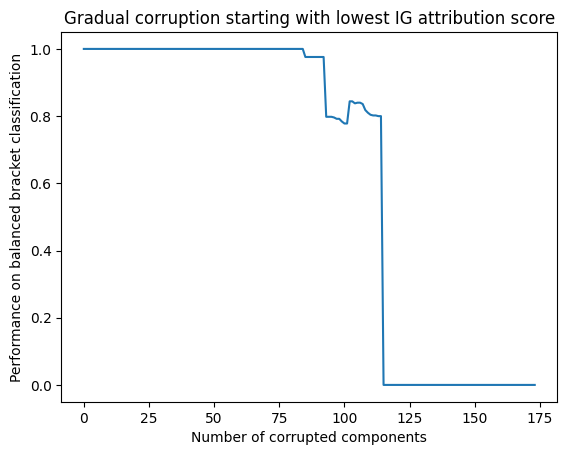

In [ ]:
plt.plot(gradual_ig_corruption_performance)
plt.title("Gradual corruption starting with lowest IG attribution score")
plt.xlabel("Number of corrupted components")
plt.ylabel("Performance on balanced bracket classification")
plt.show()

In [98]:
np.save("gradual_ig_corruption_performance_v2", gradual_ig_corruption_performance)

### Gradual ablation with Activation Patching

In [ ]:
# Repeat with activation patching results

combined_patch_results = torch.concat([mlp_patch_results.flatten(), attn_patch_results.flatten()])
sorted_patch_indices_1d = torch.argsort(combined_patch_results.abs())

sorted_patch_indices_2d = convert_1d_indices_to_2d(sorted_patch_indices_1d)

In [ ]:
# Gradually corrupt components with lowest attribution scores from activation patching

gradual_patch_corruption_performance = []

set_gradual_patch_neurons_to_keep = set([(layer, pos) for layer in range(model.cfg.n_layers) for pos in range(model.cfg.d_mlp)])
set_gradual_patch_attn_to_keep = set([(layer, pos) for layer in range(model.cfg.n_layers) for pos in range(model.cfg.n_heads)])

model.clear_contexts()
model.remove_all_hook_fns()

for idx in range(len(sorted_patch_indices_2d)):
    keep_type, keep_layer, keep_idx = sorted_patch_indices_2d[idx]
    if keep_type == NEURON_LABEL:
        set_gradual_patch_neurons_to_keep.remove((keep_layer, keep_idx))
        mlp_hook_point = get_act_name("post", keep_layer)
        model.add_hook(mlp_hook_point, lambda act, hook: ablate_neuron_hook(act, hook, corrupted_dataset_cache, set_gradual_patch_neurons_to_keep.copy()))
    else:
        set_gradual_patch_attn_to_keep.remove((keep_layer, keep_idx))
        attn_hook_point = get_act_name("result", keep_layer)
        model.add_hook(attn_hook_point, lambda act, hook: ablate_attn_hook(act, hook, corrupted_dataset_cache, set_gradual_patch_attn_to_keep.copy()))

    _, performance = test_loaded_bracket_model_on_dataset(model, clean_dataset[:500], clean_is_balanced[:500])
    print(performance)
    gradual_patch_corruption_performance.append(performance)

model.remove_all_hook_fns()

In [ ]:
plt.plot(gradual_patch_corruption_performance)
plt.title("Gradual corruption starting with lowest activation patching attribution score")
plt.xlabel("Number of corrupted components")
plt.ylabel("Performance on balanced bracket classification")
plt.show()

# Next steps and further ideas

- Investigate out-of-distribution error idea further
    - Why do attention head scores change so dramatically?
    - TBF approximations to activation patching use IG with clean/corrupt baselines
- Investigate alternative hypotheses for discrepancies in results
    - Generic components: identify components which are always highlighted as important by IG
    - Interpolation: results of IG attribution might match the cumulative scores from causal tracing with a range of different counterfactual activations, or they might be OOD.
    - IG captures cross-layer dynamics, while patching isolates single-layer effects unnaturally: patch activations at target components but also on downstream layers (path patching)

- Complete gradual ablation for causal tracing, and investigate performance results

Since both methods rely on counterfactual reasoning, I wonder if there is some way to generate counterfactual inputs for a target component, such that causal tracing can identify that target component.

- Connect counterfactuals and activation patching templates
- It would be difficult to extract the original counterfactual input, because the space of activation possibilities at a target layer is infinite.

Future steps:

- Extrapolate to full-sized transformer model
- Test alternative attribution methods